## Dataset and Dataloader

In [1]:
!curl -L "https://drive.google.com/uc?export=download&id=14Bgxb7ft4QJy97KhIQ0yYHk_7yQgE-Nr&confirm=t" -o ESOGU_ToyDS_S4096AB.tar
!mkdir -p ESOGU_ToyDS_S4096AB
!tar xvf ESOGU_ToyDS_S4096AB.tar --directory ESOGU_ToyDS_S4096AB > /dev/null 2>&1

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 10.5M  100 10.5M    0     0  13.2M      0 --:--:-- --:--:-- --:--:-- 13.2M


In [2]:
import glob
import os
import time
import torch
import random
import itertools
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from sklearn.metrics import confusion_matrix
from torchvision.datasets.folder import DatasetFolder

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

DATA_PATH = "./ESOGU_ToyDS_S4096AB/"
BATCH_SIZE = 32
USE_CPU = False
NUM_EPOCHS = 100
EXT = (".npy", )

In [3]:
class ESOGU_ToyDS(DatasetFolder):
    def __init__(
        self,
        root,
        transform=None,
        target_transform=None,
        loader=None,
        is_valid_file=None,
    ):
        super().__init__(
            root,
            loader,
            EXT if is_valid_file is None else None,
            transform=transform,
            target_transform=target_transform,
            is_valid_file=is_valid_file,
        )

def Normalize(points):
    norm_pointcloud = points - np.mean(points, axis=0) 
    norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))
    return norm_pointcloud

def ToTensor(points):
    return torch.from_numpy(points)
    
def pcshow(xs,ys,zs):
    
    marker_conf = {
        "size": 2,
        "line": {"width": 2, "color": "DarkSlateGrey"}
    }
    data=[go.Scatter3d(x=xs, y=ys, z=zs, mode='markers')]
    fig = go.Figure(data)
    fig.update_traces(marker=marker_conf, selector={"mode": "markers"})
    fig.show()

transform = transforms.Compose([
                                Normalize,
                                ToTensor,
                                ])

In [4]:
loader = np.load
train_dataset = ESOGU_ToyDS(root=DATA_PATH + "train", loader=loader, transform=transform)
test_dataset = ESOGU_ToyDS(root=DATA_PATH + "test", loader=loader, transform=transform)

trainDataLoader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=2)
testDataLoader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=2)

In [5]:
batch = next(iter(trainDataLoader))[0]
x, y, z = batch[9].T
pcshow(x, y, z)

In [6]:
def sample_and_group(npoint, radius, nsample, xyz, points, returnfps=False):
    B, N, C = xyz.shape
    S = npoint
    fps_idx = farthest_point_sample(xyz, npoint)  # [B, npoint, C]
    new_xyz = index_points(xyz, fps_idx)
    idx = query_ball_point(radius, nsample, xyz, new_xyz)
    grouped_xyz = index_points(xyz, idx)  # [B, npoint, nsample, C]
    grouped_xyz_norm = grouped_xyz - new_xyz.view(B, S, 1, C)
    if points is not None:
        grouped_points = index_points(points, idx)
        new_points = torch.cat(
            [grouped_xyz_norm, grouped_points], dim=-1
        )  # [B, npoint, nsample, C+D]
    else:
        new_points = grouped_xyz_norm
    if returnfps:
        return new_xyz, new_points, grouped_xyz, fps_idx
    else:
        return new_xyz, new_points


def sample_and_group_all(xyz, points):
    device = xyz.device
    B, N, C = xyz.shape
    new_xyz = torch.zeros(B, 1, C).to(device)
    grouped_xyz = xyz.view(B, 1, N, C)
    if points is not None:
        new_points = torch.cat([grouped_xyz, points.view(B, 1, N, -1)], dim=-1)
    else:
        new_points = grouped_xyz
    return new_xyz, new_points

def random_point_dropout(batch_pc, max_dropout_ratio=0.875):
    for b in range(batch_pc.shape[0]):
        dropout_ratio = np.random.random() * max_dropout_ratio  # 0~0.875
        drop_idx = np.where(np.random.random((batch_pc.shape[1])) <= dropout_ratio)[0]
        if len(drop_idx) > 0:
            batch_pc[b, drop_idx, :] = batch_pc[b, 0, :]  # set to the first point
    return batch_pc

def random_scale_point_cloud(batch_data, scale_low=0.8, scale_high=1.25):
    B, N, C = batch_data.shape
    scales = np.random.uniform(scale_low, scale_high, B)
    for batch_index in range(B):
        batch_data[batch_index, :, :] *= scales[batch_index]
    return batch_data

def shift_point_cloud(batch_data, shift_range=0.1):
    B, N, C = batch_data.shape
    shifts = np.random.uniform(-shift_range, shift_range, (B, 3))
    for batch_index in range(B):
        batch_data[batch_index, :, :] += shifts[batch_index, :]
    return batch_data

def farthest_point_sample(xyz, npoint):
    device = xyz.device
    B, N, C = xyz.shape
    centroids = torch.zeros(B, npoint, dtype=torch.long).to(device)
    distance = torch.ones(B, N).to(device) * 1e10
    farthest = torch.randint(0, N, (B,), dtype=torch.long).to(device)
    batch_indices = torch.arange(B, dtype=torch.long).to(device)
    for i in range(npoint):
        centroids[:, i] = farthest
        centroid = xyz[batch_indices, farthest, :].view(B, 1, 3)
        dist = torch.sum((xyz - centroid) ** 2, -1)
        mask = dist < distance
        distance[mask] = dist[mask]
        farthest = torch.max(distance, -1)[1]
    return centroids

def index_points(points, idx):
    device = points.device
    B = points.shape[0]
    view_shape = list(idx.shape)
    view_shape[1:] = [1] * (len(view_shape) - 1)
    repeat_shape = list(idx.shape)
    repeat_shape[0] = 1
    batch_indices = (
        torch.arange(B, dtype=torch.long).to(device).view(view_shape).repeat(repeat_shape)
    )
    new_points = points[batch_indices, idx, :]
    return new_points

def square_distance(src, dst):
    B, N, _ = src.shape
    _, M, _ = dst.shape
    dist = -2 * torch.matmul(src, dst.permute(0, 2, 1))
    dist += torch.sum(src ** 2, -1).view(B, N, 1)
    dist += torch.sum(dst ** 2, -1).view(B, 1, M)
    return dist

def query_ball_point(radius, nsample, xyz, new_xyz):
    device = xyz.device
    B, N, C = xyz.shape
    _, S, _ = new_xyz.shape
    group_idx = torch.arange(N, dtype=torch.long).to(device).view(1, 1, N).repeat([B, S, 1])
    sqrdists = square_distance(new_xyz, xyz)
    group_idx[sqrdists > radius**2] = N
    group_idx = group_idx.sort(dim=-1)[0][:, :, :nsample]
    group_first = group_idx[:, :, 0].view(B, S, 1).repeat([1, 1, nsample])
    mask = group_idx == N
    group_idx[mask] = group_first[mask]
    return group_idx

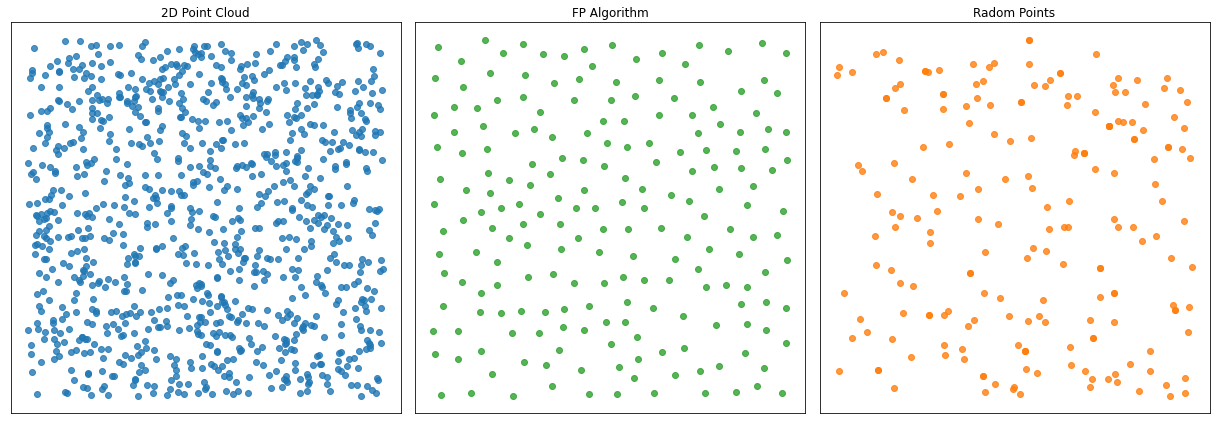

In [7]:
def fpa_2d(xy, npoint):
    B, N, _ = xy.shape
    centroids = torch.zeros(B, npoint)
    distance = torch.ones(B, N,) * 1e10
    farthest = torch.randint(0, N, (B,))
    batch_indices = torch.arange(B)
    for i in range(npoint):
        centroids[:, i] = farthest
        centroid = xy[batch_indices, farthest, :].view(B, 1, 2)
        dist = torch.sum((xy - centroid) ** 2, -1)
        mask = dist < distance
        distance[mask] = dist[mask]
        farthest = torch.max(distance, -1)[1]
    return centroids.type(torch.long)

xy = torch.randint(low=0, high=1000, size=(1000, 2), dtype=torch.float)
fpi = fpa_2d(xy.unsqueeze(0), npoint=200)
fp = xy[fpi].squeeze()
rpi = torch.randint(0, 1000, (200,))
rp = xy[rpi].squeeze()

fig, axes = plt.subplots(1,3, figsize=(17, 6))

axes[0].scatter(xy[:, 0], xy[:, 1], alpha=0.8)
axes[0].set_title('2D Point Cloud')
axes[0].axes.xaxis.set_visible(False)
axes[0].axes.yaxis.set_visible(False)

axes[1].scatter(fp[:, 0], fp[:, 1], alpha=0.8, c='#2ca02c')
axes[1].set_title('FP Algorithm')
axes[1].axes.xaxis.set_visible(False)
axes[1].axes.yaxis.set_visible(False)

axes[2].scatter(rp[:, 0], rp[:, 1], alpha=0.8, c='#ff7f0e')
axes[2].set_title('Radom Points')
axes[2].axes.xaxis.set_visible(False)
axes[2].axes.yaxis.set_visible(False)

plt.savefig('test_fpa.png', dpi=300)
plt.tight_layout()
plt.show()

In [8]:
sample = batch[0]
sample = sample.type(torch.float)

centroids = farthest_point_sample(sample.unsqueeze(0), 512).squeeze()
fpa_sampled = sample[centroids]

fig = make_subplots(
    rows=1, cols=3,
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter3d'}]],
    horizontal_spacing=0.005
    )

# Generate data
x, y, z = sample.T
fpa_x, fpa_y, fpa_z = fpa_sampled.T
rnd_x, rnd_y, rnd_z = sample[torch.randint(0, 4096, (512,))].T

marker_conf = {
        "size": 2,
        "line": {"width": 1, "color": "DarkSlateGrey"}
    }
# adding surfaces to subplots.
fig.add_trace(
    go.Scatter3d(x=x, y=y, z=z, name="Point Cloud", mode='markers'),
    row=1, col=1)

fig.add_trace(
    go.Scatter3d(x=fpa_x, y=fpa_y, z=fpa_z, name='FPA', mode='markers'),
    row=1, col=2)

fig.add_trace(
    go.Scatter3d(x=rnd_x, y=rnd_y, z=rnd_z, name='Random', mode='markers'),
    row=1, col=3)

fig.update_traces(marker=marker_conf, selector={"mode": "markers"})
fig.update_layout(
    title_text='Sampling Strategies with 3D Point Cloud',
    # height=500,
    # width=1200
)

fig.show()

In [9]:
class PointNetSetAbstraction(nn.Module):
    def __init__(self, npoint, radius, nsample, in_channel, mlp, group_all):
        super().__init__()
        self.npoint = npoint
        self.radius = radius
        self.nsample = nsample
        self.mlp_convs = nn.ModuleList()
        self.mlp_bns = nn.ModuleList()
        last_channel = in_channel
        for out_channel in mlp:
            self.mlp_convs.append(nn.Conv2d(last_channel, out_channel, 1))
            self.mlp_bns.append(nn.BatchNorm2d(out_channel))
            last_channel = out_channel
        self.group_all = group_all

    def forward(self, xyz, points):
        xyz = xyz.permute(0, 2, 1)
        if points is not None:
            points = points.permute(0, 2, 1)

        if self.group_all:
            new_xyz, new_points = sample_and_group_all(xyz, points)
        else:
            new_xyz, new_points = sample_and_group(
                self.npoint, self.radius, self.nsample, xyz, points
            )
        # new_xyz: sampled points position data, [B, npoint, C]
        # new_points: sampled points data, [B, npoint, nsample, C+D]
        new_points = new_points.permute(0, 3, 2, 1)  # [B, C+D, nsample,npoint]
        for i, conv in enumerate(self.mlp_convs):
            bn = self.mlp_bns[i]
            new_points = F.relu(bn(conv(new_points)))
        new_points = torch.max(new_points, 2)[0]
        new_xyz = new_xyz.permute(0, 2, 1)
        return new_xyz, new_points

In [10]:
class PointNet(nn.Module):
    def __init__(self, num_class, normal_channel=True):
        super().__init__()
        in_channel = 6 if normal_channel else 3
        self.normal_channel = normal_channel
        self.sa1 = PointNetSetAbstraction(npoint=512, radius=0.2, nsample=32, in_channel=in_channel, mlp=[64, 64, 128], group_all=False)
        self.sa2 = PointNetSetAbstraction(npoint=128, radius=0.4, nsample=64, in_channel=128 + 3, mlp=[128, 128, 256], group_all=False)
        self.sa3 = PointNetSetAbstraction(npoint=None, radius=None, nsample=None, in_channel=256 + 3, mlp=[256, 512, 1024], group_all=True)
        self.fc1 = nn.Linear(1024, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.drop1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.drop2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(256, num_class)

    def forward(self, xyz):
        B, _, _ = xyz.shape
        if self.normal_channel:
            norm = xyz[:, 3:, :]
            xyz = xyz[:, :3, :]
        else:
            norm = None
        l1_xyz, l1_points = self.sa1(xyz, norm)
        l2_xyz, l2_points = self.sa2(l1_xyz, l1_points)
        l3_xyz, l3_points = self.sa3(l2_xyz, l2_points)
        x = l3_points.view(B, 1024)
        x = self.drop1(F.relu(self.bn1(self.fc1(x))))
        x = self.drop2(F.relu(self.bn2(self.fc2(x))))
        x = self.fc3(x)
        x = F.log_softmax(x, -1)
        return x, l3_points


In [11]:
class Loss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, pred, target, trans_feat):
        total_loss = F.nll_loss(pred, target)
        return total_loss

def test(model, data_loader, use_cpu):
    mean_correct = []
    preds = []
    targets = []
    for points, target in data_loader:
        if not use_cpu:
            points, target = points.type(torch.float32).cuda(), target.type(torch.float32).cuda()
        points = points.transpose(2, 1)
        pred, _ = model(points)
        pred_choice = pred.data.max(1)[1]
        correct = pred_choice.eq(target.long().data).cpu().sum()
        mean_correct.append(correct.item() / float(points.size()[0]))

        preds.append(pred_choice.cpu())
        targets.append(target.cpu())

    instance_acc = np.mean(mean_correct)
    return instance_acc, torch.cat(preds), torch.cat(targets)

In [12]:
classifier = PointNet(num_class=10, normal_channel=False).to('cuda')
optimizer = torch.optim.Adam(
    classifier.parameters(),
    lr=1e-3,
    betas=(0.9, 0.999),
    eps=1e-08,
    weight_decay=1e-4
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.7)
criterion = Loss()

In [13]:
pbar = tqdm(range(NUM_EPOCHS), desc='Training')
best_acc = 0.0
all_preds, all_targets = [], []
for epoch in pbar:

    classifier = classifier.train()
    loss_list = []
    for points, target in trainDataLoader:
        optimizer.zero_grad()
        points = points.squeeze(1)
        points = points.data.numpy()
        points = random_point_dropout(points)
        points[:, :, 0:3] = random_scale_point_cloud(points[:, :, 0:3])
        points[:, :, 0:3] = shift_point_cloud(points[:, :, 0:3])
        points = torch.Tensor(points)
        points = points.transpose(2, 1)

        if not USE_CPU:
            points, target = points.cuda(), target.cuda()

        pred, trans_feat = classifier(points)
        loss = criterion(pred, target.long(), trans_feat)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())

    scheduler.step()

    with torch.no_grad():
        test_acc, preds, targets = test(classifier.eval(), testDataLoader, USE_CPU)
        if test_acc > best_acc:
            best_acc = test_acc
            savepath = str(".") + "/best_model.pth"
            state = {
                "test_acc": test_acc,
                "model_state_dict": classifier.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            }
            torch.save(state, savepath)
            
        if epoch >= NUM_EPOCHS - 20:
            all_preds.append(preds)
            all_targets.append(targets)

        pbar.set_postfix({
            "loss": loss.item(), 
            "test_acc": test_acc,
            })

pbar.close()
classifier.load_state_dict(state['model_state_dict'])

with torch.no_grad():
    overall_acc, _, _ = test(classifier.eval(), testDataLoader, USE_CPU)
    print(f"Test accuracy: {overall_acc:.4f}")

Training: 100%|██████████| 100/100 [03:22<00:00,  2.03s/it, loss=0.0172, test_acc=0.846]


Test accuracy: 0.8846


In [14]:
all_targets = torch.cat(all_targets)
all_preds = torch.cat(all_preds)

In [15]:
con_matrix = confusion_matrix(all_targets, all_preds)

# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


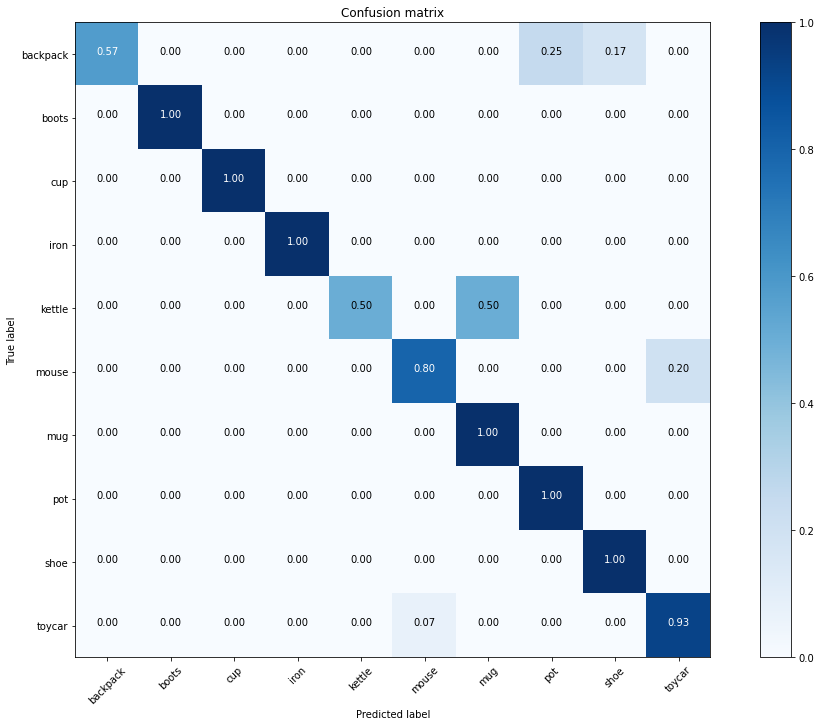

In [16]:
plt.figure(figsize=(14, 10))
plot_confusion_matrix(con_matrix, train_dataset.classes, normalize=True)

Confusion matrix, without normalization


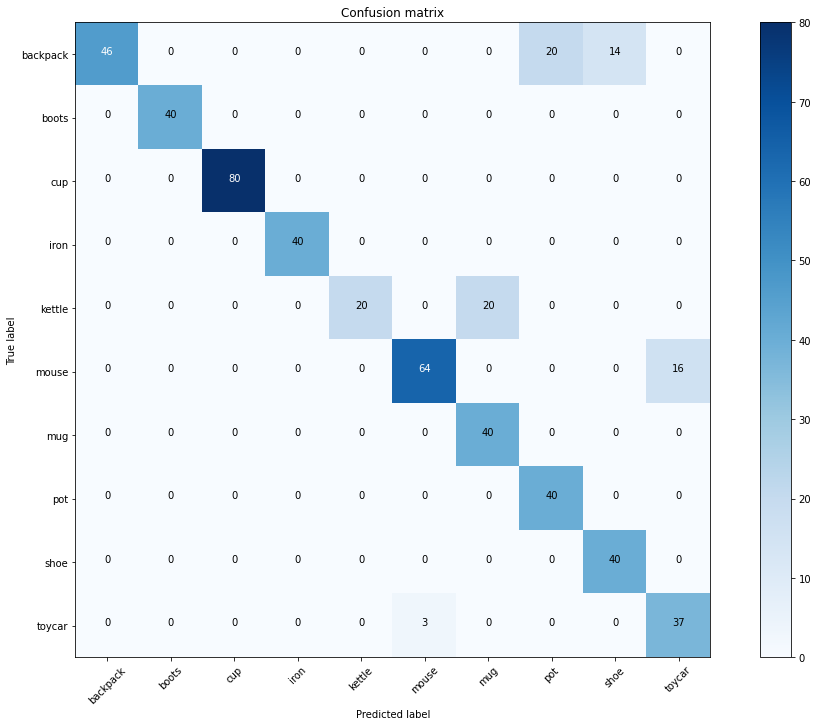

In [17]:
plt.figure(figsize=(14,10))
plot_confusion_matrix(con_matrix, train_dataset.classes, normalize=False)